In [2]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import numpy as np
from scipy.spatial.distance import euclidean
import cv2 as cv
import pdb

In [ ]:
def order_contour(contour_init):
    contour_init = contour_init[:, [1, 0]] # cv 
    max_first_index = np.max(contour_init[:, 0])
    # Create a boolean mask to identify rows with the maximum first index
    filtered_data = contour_init[:, 0] == max_first_index
    min_second_index = np.min(contour_init[filtered_data, 1])
    # find index of max first index and min second index
    index = np.where((contour_init[:, 0] == max_first_index) & (contour_init[:, 1] == min_second_index))[0][0]
    rotated_arr = np.concatenate((contour_init[index:], contour_init[:index]))
    return rotated_arr

In [ ]:
def calculate_starGT(instance_segmentation_map, n_rays = 32):
        """
        Calculate object prob for each pixel in the image.
        Args:
        - instance_segmentation_map: A 2D numpy array representing the instance segmentation map.
        - n_rays: The number of rays to sample for each instance.
        Returns:
        - object_probabilities: A 2D numpy array of the same shape as the input image with object probabilities.
        - star_distances: A 3D numpy array of shape (H, W, n_rays) with distances to the n_rays star points.
        - angles: A 3D numpy array of shape (H, W, n_rays) with angles to the n_rays star points.
        """

        # init the object probs with zeros
        object_probabilities = np.zeros_like(instance_segmentation_map, dtype=float)
        star_distances = np.zeros((instance_segmentation_map.shape[0],instance_segmentation_map.shape[1],n_rays), dtype=float)
        angles = np.zeros_like(star_distances, dtype=float)
        # iterate over each instance
        for inst in np.unique(instance_segmentation_map)[1:]:
            instance_pixels = (instance_segmentation_map == inst)
            contour_initial, _ = cv.findContours(instance_pixels.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
            contour_initial = contour_initial[0][:, 0, :]
            contour = order_contour(contour_initial)
            # randomly sample n_rays points on the boundary
            contour_n = contour[np.linspace(0, len(contour) - 1, n_rays).astype(int)]

            # iterate over each pixel in the instance
            for i in range(instance_segmentation_map.shape[0]):
                for j in range(instance_segmentation_map.shape[1]):
                    if instance_pixels[i,j]:
                        distances_to_background = np.linalg.norm(
                        contour - np.array([i, j]), axis=1
                        )
                        min_distance = np.min(distances_to_background)
                        # normalize to [0, 1]
                        try:
                            object_probabilities[i, j] = min_distance / distances_to_background.max()
                        except:
                            object_probabilities[i, j] = 0
                        # calculate the distance from instace pixel to each ray point using np.linalg.norm
                        star_distances[i,j] = np.linalg.norm(contour_n - np.array([i, j]), axis=1)
                        # calc the angles with respect to the j-axis 
                        angles_ray = np.arctan2(contour_n[:, 1] - j, contour_n[:, 0] - i)
                        # angles from [-pi,pi] --> [0, 2pi] and normalize to [0, 1]
                        angles[i,j] = ((angles_ray + 2 * np.pi) % (2 * np.pi)) / (2 * np.pi)               
        return object_probabilities, star_distances, angles 

In [ ]:
labels_path = "./data/labels.npy"
images_path = "./data/images.npy"

instance_map = np.load(labels_path)[5,:,:,0]
image = np.load(images_path)[5,:,:,:]

In [ ]:
object_probabilities, star_distances, angles  = calculate_starGT(instance_map, n_rays = 16)


In [ ]:
plt.imshow(object_probabilities)

In [ ]:
# select points where object_probabilities > 0.72
points = np.argwhere(object_probabilities > 0.68)
plt.imshow(instance_map)
plt.scatter(points[:,1], points[:,0], s=2, c='r')
plt.show()

In [ ]:
import numpy as np

def calculate_endpoint(start_point, length, angle_rad):
    x_start, y_start = start_point
    delta_x = length * np.cos(angle_rad)
    delta_y = length * np.sin(angle_rad)
    x_end = x_start + delta_x
    y_end = y_start + delta_y
    return x_end, y_end

start_point = np.array([141,  56])
length = star_distances[start_point[0], start_point[1]]
angle_rad = angles[start_point[0], start_point[1]] * 2 * np.pi
x , y = calculate_endpoint(start_point, length, angle_rad)
print(x,y)

In [ ]:
# calculate 99.5 percentile object_probabilities
percentile_99_5 = np.percentile(object_probabilities, 99.5)
# select points whcih are atleast 5 pixels away from each other
def filter_points(points, x):
    filtered_points = []
    
    for i, point1 in enumerate(points):
        is_valid = True
        
        for j, point2 in enumerate(points):
            if i != j:  # Avoid comparing the point to itself
                distance = np.linalg.norm(np.array(point1) - np.array(point2))
                if distance < x:
                    is_valid = False
                    break  # No need to check other points
                
        if is_valid:
            filtered_points.append(point1)
    
    return np.array(filtered_points)

# select points where object_probabilities > percentile_99.5
mid_points = np.argwhere(object_probabilities > percentile_99_5)
# filter points
filtered_points = filter_points(mid_points, 5)
plt.imshow(image)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
for point in filtered_points:
    start_point = point
    length = star_distances[start_point[0], start_point[1]]
    angle_rad = angles[start_point[0], start_point[1]] * 2 * np.pi
    print(point)
    print(angle_rad)
    x , y = calculate_endpoint(start_point, length, angle_rad)
    plt.plot(y,x, c='black')
plt.show()

In [ ]:
star_d = (star_distances[filtered_points[:,0],filtered_points[:,1]])
star_theta = (angles[filtered_points[:,0],filtered_points[:,1]] * 2 * np.pi)
delta_x = star_d * np.cos(star_theta)
delta_y = star_d * np.sin(star_theta)
x_end = filtered_points[:,0].reshape(-1,1) + delta_x
y_end = filtered_points[:,1].reshape(-1,1) + delta_y

In [ ]:
plt.imshow(instance_map)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y_end,x_end,s=1, c='black')

In [ ]:
plt.imshow(image)
plt.scatter(filtered_points[:,1], filtered_points[:,0], s=1, c='r')
plt.scatter(y_end,x_end,s=1, c='black')

In [ ]:
fig, ax = plt.subplots()

for i in range(len(filtered_points)):
    for j in range(8):
        ax.quiver(filtered_points[i,1], filtered_points[i,0], delta_x[i,j], delta_y[i,j], angles='xy', scale_units='xy', scale=1, color='b')

## check circular loss

In [ ]:
import torch

In [ ]:
from utils.circular_loss import CircularAELoss
criterion = CircularAELoss()
a = torch.tensor([[0.2,0.4,0.6],[0.8,1.0,0.6]])
b = torch.tensor([[1,0,1],[0,1,0]])
loss = criterion(a,b)

In [ ]:
loss

## Create a toy data set to test 

In [ ]:
images_path = "./data/images.npy"
labels_path = "./data/labels.npy"

images = np.load(images_path)
labels = np.load(labels_path)

toy_images = images[:2400,:,:,:]
toy_labels = labels[:2400,:,:,:]

save_images_path = "./data/images_50.npy"
save_labels_path = "./data/labels_50.npy"

np.save(save_images_path, toy_images)
np.save(save_labels_path, toy_labels)

## NMS

In [3]:
obj_prob = np.load("./temp/pred_prob.npy")
star_dist = np.load("./temp/pred_dist.npy")
angles = np.load("./temp/pred_angles.npy")

In [4]:
obj_prob = obj_prob[0,:,:]
star_dist = star_dist[0,:,:,:]
angles = angles[0,:,:,:]

In [5]:
obj_prob.shape, star_dist.shape, angles.shape

((256, 256), (256, 256, 16), (256, 256, 16))

In [6]:
def calculate_endpoint(start_point, length, angle_rad):
    x_start, y_start = start_point[0], start_point[1]
    delta_x = length * np.cos(angle_rad)
    delta_y = length * np.sin(angle_rad)
    x_end = x_start + delta_x
    y_end = y_start + delta_y
    return x_end, y_end

In [7]:
points = np.argwhere(obj_prob > 0.35)
prob_points = obj_prob[points[:,0],points[:,1]]
sorted_points = points[np.argsort(prob_points)[::-1]]
num_points = sorted_points.shape[0]
X = []
Y = []
for point in sorted_points:
    len = star_dist[point[0],point[1]]
    theta = angles[point[0],point[1]] * 2 * np.pi
    x , y = calculate_endpoint(point, len, theta)
    X.append(x)
    Y.append(y)
X1 = np.array(X)
Y1 = np.array(Y)
end_points = np.stack((Y1,X1), axis=-1).astype(int)
mask_nms = np.zeros((num_points,256,256), dtype=np.uint8)
for i in range(num_points):
    cv.fillPoly(mask_nms[i], pts=[end_points[i]], color=1)

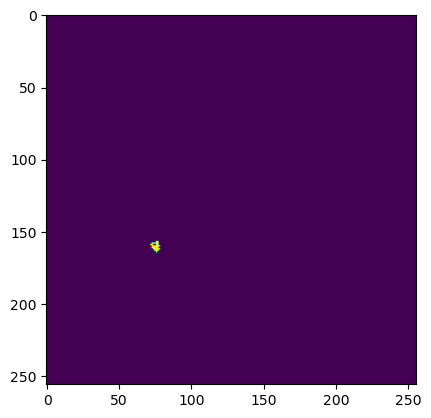

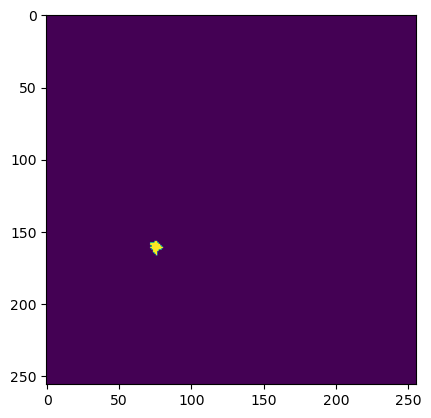

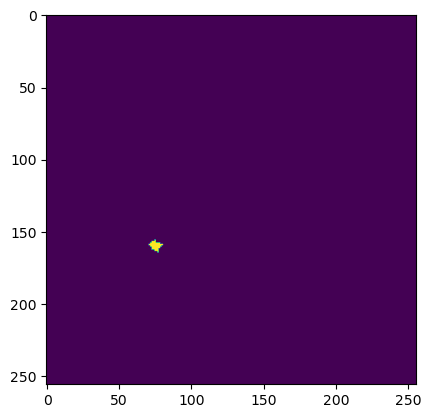

In [8]:
for i in range(end_points.shape[0]):
    plt.imshow(mask_nms[i])
    plt.show()

In [25]:
def non_max_suppression(masks, iou_threshold):
    """
    Perform Non-Maximum Suppression (NMS) on a list of masks.
    
    Args:
        masks (numpy.ndarray): A numpy array of shape (n, 256, 256) containing binary masks.
        probabilities (list of floats): List of confidence probabilities for each mask (length n).
        iou_threshold (float): IoU (Intersection over Union) threshold for suppression.
        
    Returns:
        List of selected masks after NMS.
    """
    selected_masks = []  # List to store selected masks
    n = masks.shape[0]  # Number of masks

    # Iterate through masks in descending order of probability
    for i in range(n):
        mask = masks[i]
        keep_mask = True  # Flag to determine if the mask should be kept
        # Calculate IoU with previously selected masks
        size = 0
        for _ in selected_masks:
            size += 1
        for j in range(size):
            iou = np.sum(mask & selected_masks[j]) / np.sum(mask | selected_masks[j])
            
            # If IoU is above the threshold, suppress the current mask
            if iou > iou_threshold:
                keep_mask = False
                break
        
        # If the mask is not suppressed, add it to the selected masks list
        if keep_mask:
            selected_masks.append(mask)
    
    return selected_masks

In [26]:
final_masks = non_max_suppression(mask_nms, 0.5)

In [30]:
np.array(final_masks).shape

(1, 256, 256)

In [24]:
# create a python list
baba = []
#find length of the list
n = size(baba)

TypeError: 'int' object is not callable

In [20]:
inp_lst = ['Python', 'Java', 'Ruby', 'JavaScript']
size = 0
for x in inp_lst:
    size += 1
print(size)

4
